<h1><center>SIIM-FISABIO-RSNA COVID-19 Detection</center></h1>
<h2><center>Identify and localize COVID-19 abnormalities on chest radiographs</center></h2>

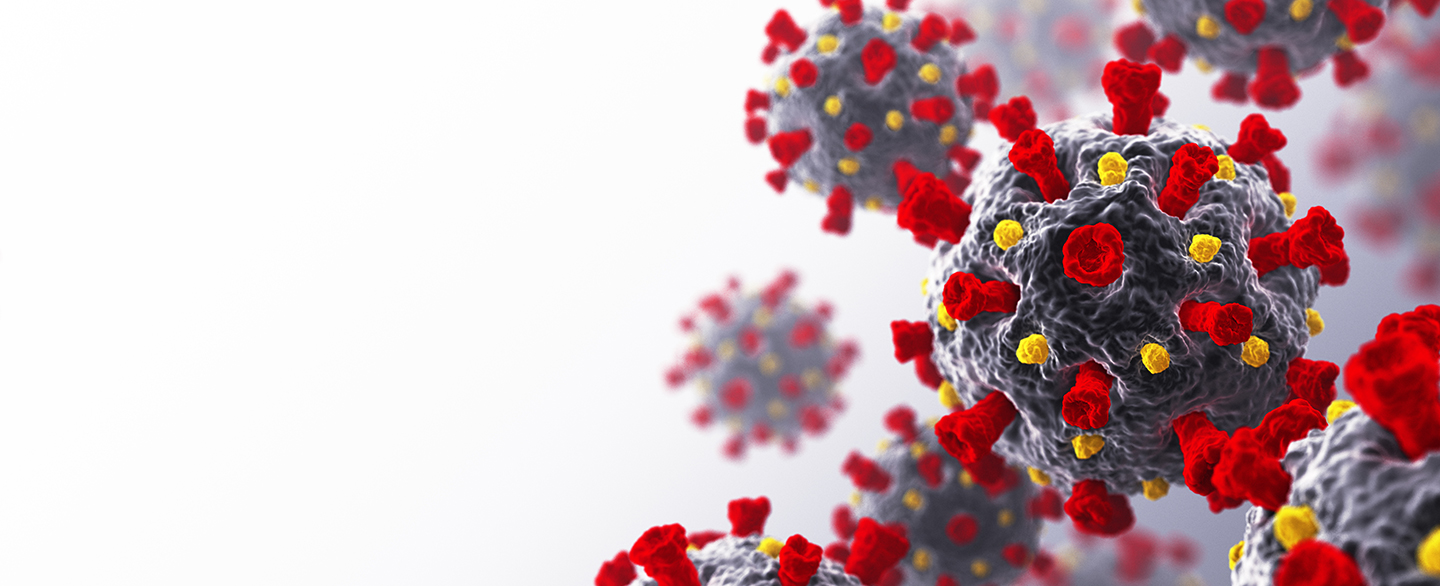

<h3><center>1. Understand the Competition</center></h3>
<ul>
  <li>COVID-19 looks very similar to other viral and bacterial pneumonias on chest radiographs, which makes it difficult to diagnose. </li>
  <li>Currently, COVID-19 can be diagnosed via polymerase chain reaction to detect genetic material from the virus or chest radiograph. However, it can take a few hours and sometimes days before the molecular test results are back. By contrast, chest radiographs can be obtained in minutes. </li>
  <li>In this competition, we’ll identify and localize COVID-19 abnormalities on chest radiographs. In particular, we'll categorize the radiographs as negative for pneumonia or typical, indeterminate, or atypical for COVID-19. </li>
  <li><b>In simple words, we hope to develop a model to help radiologists diagnose the millions of COVID-19 patients more confidently and quickly.</b></li>
</ul>

<h3><center>2. Exploratory Data Analysis (EDA)</center></h3>

In [ ]:
# Libraries
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from pandas import DataFrame
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from tqdm.notebook import tqdm

# Image processing and Computer Vision
from skimage import exposure
import cv2
# Package designed to manipulate data elements in DICOM files 

import pydicom
#Image Transformation
from pydicom.pixel_data_handlers.util import apply_voi_lut

from fastai.vision.all import *
from fastai.medical.imaging import *



#### Now let's Understand the DATA....

In [ ]:
#train_image
train_image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_image_df.head(2)

In [ ]:
#train_study
train_study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
train_study_df.head()

<h3>Data Description</h3>
    
    
<ol>
  <li><b>Train Data:</b> The train dataset comprises 6,334 chest scans in DICOM format. Train Data has two .csv files (refer above)-</li>
    <ul>
        <li><b>train_study_level:</b> The study ID here relates directly to the study-level predictions.The train study-level metadata, with one row for each study, includes correct labels.</li>
        <h5>Columns:-</h5><ol>
            <li><b>id:</b>unique study identifier</li>
            <li><b>Negative for Pneumonia:</b>1 if the study is negative for pneumonia, 0 otherwise</li>
            <li><b>Typical Appearance:</b>1 if the study has this appearance, 0 otherwise</li>
            <li><b>Indeterminate Appearance:</b>1 if the study has this appearance, 0 otherwise</li>
            <li><b>Atypical Appearance:</b>1 if the study has this appearance, 0 otherwise</li>
        </ol>
        <br>
        <li><b>train_image_level:</b>The image ID is the ID used for image-level predictions.The train image-level metadata, with one row for each image, includes both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.</li> 
        <h5>Columns:-</h5>
        <ol>
            <li><b>id:</b>unique image identifier</li>
            <li><b>boxes:</b>bounding boxes in easily-readable dictionary format</li>
            <li><b>label:</b>the correct prediction label for the provided bounding boxes</li>
            <br>
        In <b>Label Column</b>, the format is as follows: `[class ID] [confidence score] [bounding box]`
            <ul>
                <li><b>Class ID:</b> Either opacity or none</li>
                <li><b>Confidence score:</b> confidence from your neural network model. If none, the confidence is 1.</li>
                <li><b>Bounding box:</b>typical xmin ymin xmax ymax format. If class ID is none,bounding box is 1 0 0 1 1.</li>
                The bounding boxes are also provided in easily readable dictionary format in column <b>boxes</b>
            </ul>
        </ol>
     </ul>
    <br>
  <li><b>Test folder:</b>The test dataset is of roughly the same scale as the training dataset.</li>
  <li><b>sample_submission.csv:</b> A sample submission file contains all image- and study-level IDs.</li>
</ol>
        

In [ ]:
# Bar plot function defination
def viz_bar_plot(df,x,x_title,y,title,colors=None,text=None):
    fig = px.bar(x=x,
                 y=y,
                 text=text,
                 labels={x: x_title.title()},   
                 data_frame=df,
                 color=colors,
                 barmode='group',
                 template="simple_white")
    texts = [df[col].values for col in y]
    for i, t in enumerate(texts):
        fig.data[i].text = t
        fig.data[i].textposition = 'inside'  
    fig['layout'].title=title
    fig.update_layout(title_font_size=19)
    fig.update_layout(title_font_family='Droid Serif')
    fig.update_layout(width=800,height=500)
    for trace in fig.data:
        trace.name = trace.name.replace('_',' ').title()
    fig.update_yaxes(tickprefix="", showgrid=True)
    fig.show()

In [ ]:
# Study Data
# create 'target' column in train_study_df dataset
train_study_df['target']='Negative for Pneumonia'
train_study_df.loc[train_study_df['Typical Appearance']==1,'target']='Typical Appearance'
train_study_df.loc[train_study_df['Indeterminate Appearance']==1,'target']='Indeterminate Appearance'
train_study_df.loc[train_study_df['Atypical Appearance']==1,'target']='Atypical Appearance'


In [ ]:
train_study_df1=train_study_df.groupby(['target']).size().reset_index(name='counts')
train_study_df1

In [ ]:
# Bar Visulaization of label categories
viz_bar_plot(train_study_df1,
         'target',
         'target',
         ['counts'],
         title='Target Label Count')

In [ ]:
# Image Data
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])
train_study_df2=train_image_df.groupby(['class']).size().reset_index(name='counts')
viz_bar_plot(train_study_df2,
         'class',
         'class',
         ['counts'],
         title='Class')

In [ ]:
# Split label column and extract the values of x_min, y_min,x_max, y_max 
train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))
train_image_df.head(3)

In [ ]:
# merge study and image dataset on id column
train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
del train_study_df['id']
train_image_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')
train_image_df.head(2)

In [ ]:
# Label classes probablity distribution
fig, ax = plt.subplots(2,2,figsize=(18,15))
sns.kdeplot(train_image_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#5DADE2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=15)
ax[0,0].set(xlabel=None)
sns.kdeplot(train_image_df["Typical Appearance"], shade=True,ax=ax[0,1],color="#27AE60")
ax[0,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=15)
ax[0,1].set(xlabel=None)
sns.kdeplot(train_image_df["Indeterminate Appearance"], shade=True,ax=ax[1,0],color="#E74C3C")
ax[1,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=15)
ax[1,0].set(xlabel=None)
sns.kdeplot(train_image_df["Atypical Appearance"], shade=True,ax=ax[1,1],color="#FFBA08")
ax[1,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=15)
ax[1,1].set(xlabel=None)
plt.show()

#### Image Visualization

In [ ]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # 'VOI LUT' is used to transform raw DICOM data to "human-friendly" view.
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted -> fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(5, 5), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=5, is_rgb=True, title="", cmap='gray', img_size=(300,300)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [ ]:
dicom_paths = get_dicom_files('../input/siim-covid19-detection/train')
imgs = [dicom2array(path) for path in dicom_paths[-12:]]
plot_imgs(imgs)

In [ ]:
train_image_df = train_image_df[~train_image_df.boxes.isnull()] 
class_names = ['Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'] # we have 3 positive classes
unique_classes = np.unique(train_image_df[class_names].values, axis=0)

#### Plot images with Bounding Box

In [ ]:
from termcolor import colored
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.5)
    plt.tick_params(axis='both', labelsize=0, length = 0)

print(colored('1.Typical Appearance', 'blue'))
print(colored('2.Indeterminate Appearance', 'red'))
print(colored('3.Atypical Appearance', 'yellow'))

palette = ["#4209ff","#f72545","#FFBA08"]
custom_palette(palette)

#### All Classes

In [ ]:
from glob import glob
imgs = []
label2color = {
    '[1, 0, 0]': [66,9,255], # Typical Appearance
    '[0, 1, 0]': [247,37,69], # Indeterminate Appearance
    '[0, 0, 1]': [255,186,8], # Atypical Appearance
}
thickness = 3
scale = 6

for _, row in train_image_df[train_image_df['Negative for Pneumonia']==0].iloc[12:20].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)


#### Indeterminate Appearance

In [ ]:
imgs = []

for _, row in train_image_df[train_image_df['Indeterminate Appearance'] == 1].iloc[2:6].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

#### Atypical Appearance

In [ ]:
imgs = []

for _, row in train_image_df[train_image_df['Atypical Appearance'] == 1].iloc[0:4].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

<h2><center>3. Model</center></h2>

#### In Progress..

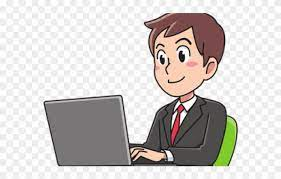